In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
import random
import wandb
import matplotlib.pyplot as plt

In [2]:
# Poisson Image Editing function for synthetic anomaly creation
def poisson_edit(source, destination, mask):
    center = (destination.shape[1] // 2, destination.shape[0] // 2)
    blended = cv2.seamlessClone(source, destination, mask, center, cv2.NORMAL_CLONE)
    return blended

In [3]:
# Custom Dataset class with Poisson editing for synthetic anomalies
class MVTecNSADataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        for root, _, files in os.walk(os.path.join(root_dir, split)):
            for fname in files:
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError("Index out of range for dataset.")
        
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image at path {img_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        # Apply Poisson image editing to create synthetic anomalies
        if self.split == "train":
            source_idx = random.randint(0, len(self.image_paths) - 1)
            source_img_path = self.image_paths[source_idx]
            source_image = cv2.imread(source_img_path)
            if source_image is None:
                raise ValueError(f"Source image at path {source_img_path} could not be loaded.")
            source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
            source_image = cv2.resize(source_image, (256, 256))

            mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
            h, w = mask.shape
            top_left = (random.randint(0, w // 2), random.randint(0, h // 2))
            bottom_right = (random.randint(w // 2, w), random.randint(h // 2, h))
            mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255

            image = poisson_edit(source_image, image, mask)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        return image, 0  # Label 0 for normal data

In [4]:
# Visualize dataset samples
# Expected output: Displays 8 images from the dataset
# If there are any issues with image loading, an error message is printed
# Analyze dataset: Prints the total number of images and displays some samples
def visualize_dataset_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        try:
            image, _ = dataset[i]
            image = image.permute(1, 2, 0).numpy()
            axes[i].imshow(image)
            axes[i].axis('off')
        except (ValueError, IndexError) as e:
            print(e)
            continue
    plt.show()

Total number of images in the dataset: 209


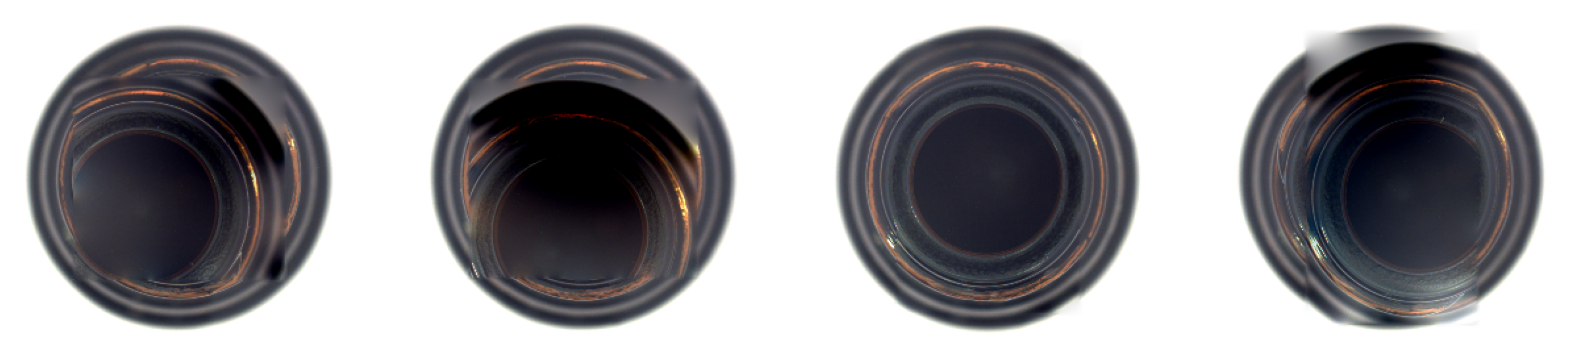

In [8]:
# Analyze dataset
# Expected output: Prints the total number of images in the dataset and visualizes 8 samples
# If images cannot be loaded, errors are printed
def analyze_dataset(dataset):
    num_images = len(dataset)
    print(f"Total number of images in the dataset: {num_images}")
    
    # Visualize some samples
    visualize_dataset_samples(dataset, num_samples=4)

# Analyze and visualize the training dataset
analyze_dataset(MVTecNSADataset("./datasets/mvtec/bottle/", split="train"))

In [7]:
# Model class: ResNet Encoder-Decoder
# Expected output: Initializes the ResNet-based encoder-decoder model
class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()
        # Encoder: Using a simplified ResNet-like structure
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Decoder: Mirror of the encoder with transposed convolutions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [8]:
# Initialize Weights and Biases (wandb)
# Expected output: Initializes the wandb run
wandb.init(project="nsa-mvtec", entity="sameerhashmi1995")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


In [9]:
# Set device
# Expected output: Determines whether to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# Load the MVTec dataset with NSA synthetic anomalies
# Expected output: Loads training and validation datasets from the given directory
data_dir = "./datasets/mvtec/bottle/"  # Update with the correct path
train_dataset = MVTecNSADataset(data_dir, split="train")
val_dataset = MVTecNSADataset(data_dir, split="test")

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [13]:
# Initialize the ResNetEncDec model
# Expected output: Initializes the model and transfers it to the appropriate device
model = ResNetEncDec().to(device)
model

ResNetEncDec(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Seque

In [14]:
# Define optimizer and loss function
# Expected output: Configures the Adam optimizer and MSE loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [15]:
# Training function
# Expected output: Trains the model for one epoch and returns the average loss
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [16]:
# Validation function
# Expected output: Evaluates the model on the validation set and returns the average loss
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(loader)